In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
print('colab tensorflow version:', tf.__version__)

colab tensorflow version: 2.5.0


Load the Cifar10 dataset


170500096/170498071 [==============================] - 4s 0us/step


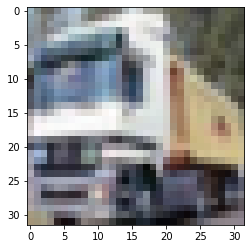

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
plt.imshow(x_train[1], cmap='gray')
plt.show()

Split train and validation data

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  test_size=0.2, shuffle=True, random_state=42)

Horizental Flip Data Augmentation

In [4]:
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(x_train)
augmented_data_flip = []
augmented_data_label_flip = []
num_augmented = 0
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=4, seed=42):
  for x, y in zip(X_batch, y_batch):
    augmented_data_flip.append(x)
    augmented_data_label_flip.append(y)
  num_augmented += 4
  if num_augmented == x_train.shape[0]:
    break

Sample wise center Augmentation

In [5]:
datagen = ImageDataGenerator(samplewise_center=True)
datagen.fit(x_train)
augmented_data_center = []
augmented_data_label_center = []
num_augmented = 0
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=4, seed=42):
  for x, y in zip(X_batch, y_batch):
    augmented_data_center.append(x)
    augmented_data_label_center.append(y)
  num_augmented += 4
  if num_augmented == x_train.shape[0]:
    break

Add augmented data's to the train set

In [6]:
x_train = np.concatenate((x_train, np.array(augmented_data_flip), np.array(augmented_data_center)), axis=0)
y_train = np.concatenate((y_train, np.array(augmented_data_label_flip), np.array(augmented_data_label_center)), axis=0)

Check the labels distribution

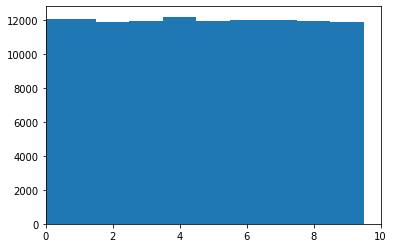

In [7]:
hist, bin_edges = np.histogram(y_train, bins=range(11))
plt.bar(bin_edges[:-1], hist, width = 1)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()   

Normalizing Features

In [8]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

One Hot Encoding train and test labels

In [9]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

Sample 10000 image for hyper parameter tuning

In [ ]:
# n = int(len(x_train) / 5) 
n = 10000
index = np.random.choice(x_train.shape[0], n, replace=False) 
x_sample_train = x_train[index]
y_sample_train = y_train[index]

Check the hyper parameters for single layer MLP network

In [ ]:
def create_model(activation='relu', units=1024, optimizer='adam'):
	# create model
  model = Sequential()
  model.add(Flatten(input_shape=x_train.shape[1:]))
  model.add(Dense(units=units, activation=activation))
  model.add(Dense(10, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=200, verbose=0)
# define the grid search parameters
activation = ['relu', 'tanh', 'sigmoid',
              'hard_sigmoid', 'linear']
units = [256, 512, 1024, 2048]
param_grid = dict(activation=activation, units=units)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_sample_train, y_sample_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.404400 using {'activation': 'relu', 'units': 2048}
0.387600 (0.012298) with: {'activation': 'relu', 'units': 256}
0.402200 (0.004423) with: {'activation': 'relu', 'units': 512}
0.402900 (0.010599) with: {'activation': 'relu', 'units': 1024}
0.404400 (0.016151) with: {'activation': 'relu', 'units': 2048}
0.371000 (0.007675) with: {'activation': 'tanh', 'units': 256}
0.372900 (0.007883) with: {'activation': 'tanh', 'units': 512}
0.363500 (0.015588) with: {'activation': 'tanh', 'units': 1024}
0.357100 (0.007248) with: {'activation': 'tanh', 'units': 2048}
0.387200 (0.005653) with: {'activation': 'sigmoid', 'units': 256}
0.380900 (0.009308) with: {'activation': 'sigmoid', 'units': 512}
0.383000 (0.015241) with: {'activation': 'sigmoid', 'units': 1024}
0.377500 (0.012272) with: {'activation': 'sigmoid', 'units': 2048}
0.386000 (0.011463) with: {'activation': 'hard_sigmoid', 'units': 256}
0.378700 (0.011630) with: {'activation': 'hard_sigmoid', 'units': 512}
0.373500 (0.006993) with:

Search for appropriate optimizer

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=200, verbose=0)
# define the grid search parameters

optimizers = ['adam', 'rmsprop', 'sgd']
param_grid = dict(optimizer=optimizers, units=[2048])

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_sample_train, y_sample_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.399200 using {'optimizer': 'adam', 'units': 2048}
0.399200 (0.011894) with: {'optimizer': 'adam', 'units': 2048}
0.332100 (0.013811) with: {'optimizer': 'rmsprop', 'units': 2048}
0.356500 (0.007064) with: {'optimizer': 'sgd', 'units': 2048}


Modify early stopping callback

In [10]:

class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self, patience=0, monitor='val_loss'):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience
    self.monitor = monitor

  def on_train_begin(self, logs=None):
    if self.monitor in ['loss', 'val_loss']:
      self.best = np.Inf
    else:
      self.best = 0
    self.wait = 0
    self.stopped_epoch = 0
  
  def on_epoch_end(self, epoch,logs=None):
    current_monitor=logs.get(self.monitor)
    bool1 = self.monitor in ['loss', 'val_loss'] and np.less(current_monitor,
                                                             self.best)
    bool2 = self.monitor in ['accuracy', 'val_accuracy'] and np.less(self.best,
                                                                     current_monitor)
    if bool1 or bool2:
      self.best = current_monitor
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      print("\nwait mode, step: %d"% self.wait)
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)
  
  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print("epoch: %d : early stopping."% self.stopped_epoch)

Plot metric value

In [11]:
def plotMetric(history, firstMetric, firstLabel, secondMetric, secondLabel, title, ylabel):
  plt.plot(history.history[firstMetric], label=firstLabel)
  plt.plot(history.history[secondMetric], label=secondLabel)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel('epoch')
  plt.legend(loc='upper left')
  plt.show()

Plot accuracy and loss

In [12]:
def plotAccuracyLoss(history):
  plotMetric(history, 'accuracy', 'train_acc', 'val_accuracy', 'val_acc', 'model accuracy', 'accuracy')
  print()
  plotMetric(history, 'loss', 'tarin_loss', 'val_loss', 'val_loss', 'model Loss', 'loss')

Evaluating the model by calculating the confusion matrix and report other metrics

In [13]:
def calculateAccuracyModel(model):
  # evaluate the keras model
  _, accuracy = model.evaluate(x_train, y_train, batch_size=100)
  print('Train Accuracy: %.2f' % (accuracy*100))
  print()
  # evaluate the keras model
  _, accuracy = model.evaluate(x_test, y_test, batch_size=100)
  print('Test Accuracy: %.2f' % (accuracy*100))

def reportPerformance(model, x, y):
  y_pred = model.predict(x)
  print('Confusion Matrix')
  print()
  conf_matrix = metrics.confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                        display_labels=range(0, 10))
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax, cmap=plt.cm.Blues)
  plt.show()
  print()
  print(conf_matrix)
  print()
  print('Classification Report')
  print(metrics.classification_report(y.argmax(axis=1), y_pred.argmax(axis=1)))

Train 2 Layer MLP

In [ ]:

model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='linear'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(25, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5)
]
history = model.fit(x_train, y_train, epochs=200, callbacks=my_callbacks,
                    batch_size=250, validation_data=(x_val, y_val), shuffle=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1290      
Total params: 6,557,066
Trainable params: 6,557,066
Non-trainable params: 0
____________________________________________

Plot the accuracy and loss

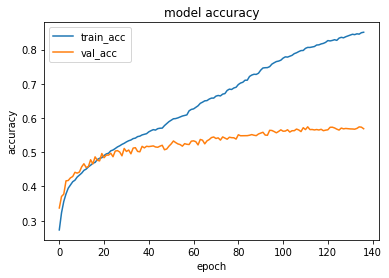

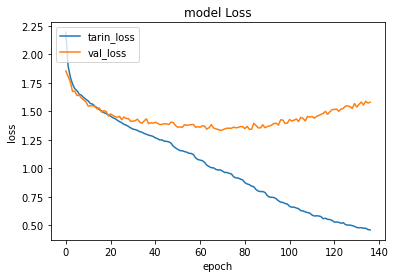

In [ ]:
plotAccuracyLoss(history)

Evaluate the model on train and test data

In [ ]:
calculateAccuracyModel(model)

1200/1200 [==============================] - 6s 5ms/step - loss: 0.3407 - accuracy: 0.9041
Train Accuracy: 90.41

100/100 [==============================] - 0s 5ms/step - loss: 1.4639 - accuracy: 0.5627
Test Accuracy: 56.27


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



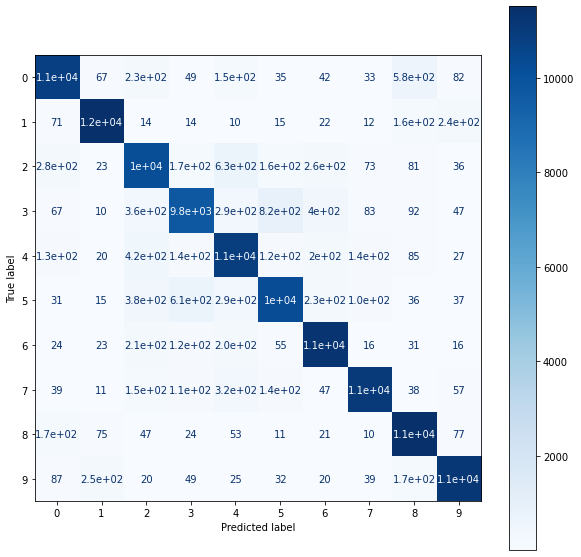


[[10815    67   230    49   146    35    42    33   582    82]
 [   71 11510    14    14    10    15    22    12   158   237]
 [  278    23 10201   170   630   161   257    73    81    36]
 [   67    10   363  9756   292   822   399    83    92    47]
 [  132    20   425   136 10920   116   199   141    85    27]
 [   31    15   382   609   292 10219   229   105    36    37]
 [   24    23   210   119   205    55 11313    16    31    16]
 [   39    11   148   114   319   141    47 11104    38    57]
 [  166    75    47    24    53    11    21    10 11465    77]
 [   87   247    20    49    25    32    20    39   174 11187]]

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     12081
           1       0.96      0.95      0.96     12063
           2       0.85      0.86      0.85     11910
           3       0.88      0.82      0.85     11931
           4       0.85      0.90      0.87     12201
           5       0

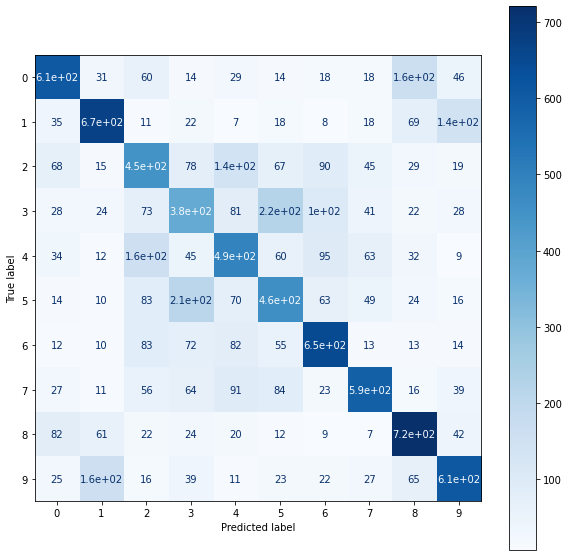


[[609  31  60  14  29  14  18  18 161  46]
 [ 35 671  11  22   7  18   8  18  69 141]
 [ 68  15 449  78 140  67  90  45  29  19]
 [ 28  24  73 377  81 223 103  41  22  28]
 [ 34  12 158  45 492  60  95  63  32   9]
 [ 14  10  83 210  70 461  63  49  24  16]
 [ 12  10  83  72  82  55 646  13  13  14]
 [ 27  11  56  64  91  84  23 589  16  39]
 [ 82  61  22  24  20  12   9   7 721  42]
 [ 25 160  16  39  11  23  22  27  65 612]]

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      1000
           1       0.67      0.67      0.67      1000
           2       0.44      0.45      0.45      1000
           3       0.40      0.38      0.39      1000
           4       0.48      0.49      0.49      1000
           5       0.45      0.46      0.46      1000
           6       0.60      0.65      0.62      1000
           7       0.68      0.59      0.63      1000
           8       0.63      0.72      0.67      1000
    

In [ ]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

Design MLP model

In [ ]:

model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='linear'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.25))
model.add(Dense(25, activation='linear'))
model.add(Dense(10, activation='softmax'))


Compile the MLP model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

Train the MLP model

In [ ]:
# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(25, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5)
]
history = model.fit(x_train, y_train, epochs=200, callbacks=my_callbacks,
                    batch_size=250, validation_data=(x_val, y_val), shuffle=True)

Epoch 1/200
480/480 [==============================] - 5s 9ms/step - loss: 1.9414 - accuracy: 0.2941 - val_loss: 1.7152 - val_accuracy: 0.3740
Epoch 2/200
480/480 [==============================] - 4s 8ms/step - loss: 1.6735 - accuracy: 0.4025 - val_loss: 1.5984 - val_accuracy: 0.4252
Epoch 3/200
480/480 [==============================] - 4s 8ms/step - loss: 1.6006 - accuracy: 0.4304 - val_loss: 1.5525 - val_accuracy: 0.4441
Epoch 4/200
480/480 [==============================] - 4s 8ms/step - loss: 1.5547 - accuracy: 0.4471 - val_loss: 1.5448 - val_accuracy: 0.4423

wait mode, step: 1
Epoch 5/200
480/480 [==============================] - 4s 8ms/step - loss: 1.5210 - accuracy: 0.4605 - val_loss: 1.5003 - val_accuracy: 0.4643
Epoch 6/200
480/480 [==============================] - 4s 8ms/step - loss: 1.4969 - accuracy: 0.4699 - val_loss: 1.4746 - val_accuracy: 0.4725
Epoch 7/200
480/480 [==============================] - 4s 8ms/step - loss: 1.4748 - accuracy: 0.4776 - val_loss: 1.5093 - 

Plot  accuracy and loss in epochs

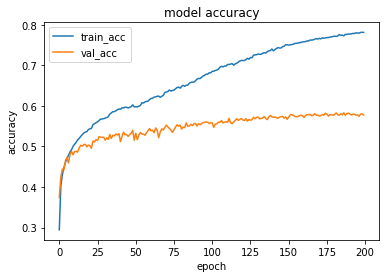

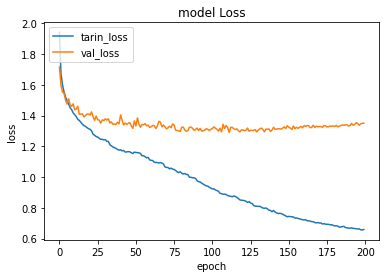

In [ ]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [ ]:
calculateAccuracyModel(model)

1200/1200 [==============================] - 5s 4ms/step - loss: 0.4606 - accuracy: 0.8534
Train Accuracy: 85.34

100/100 [==============================] - 0s 4ms/step - loss: 1.3479 - accuracy: 0.5776
Test Accuracy: 57.76


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



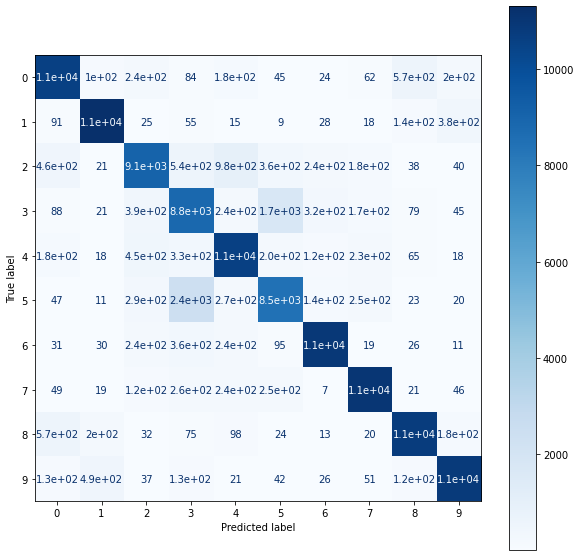


[[10584   100   244    84   176    45    24    62   567   195]
 [   91 11309    25    55    15     9    28    18   135   378]
 [  457    21  9060   540   975   359   238   182    38    40]
 [   88    21   387  8842   239  1746   316   168    79    45]
 [  178    18   448   328 10598   205   116   227    65    18]
 [   47    11   291  2427   266  8476   142   252    23    20]
 [   31    30   244   359   244    95 10953    19    26    11]
 [   49    19   122   257   238   247     7 11012    21    46]
 [  571   198    32    75    98    24    13    20 10739   179]
 [  130   490    37   131    21    42    26    51   115 10837]]

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     12081
           1       0.93      0.94      0.93     12063
           2       0.83      0.76      0.79     11910
           3       0.68      0.74      0.71     11931
           4       0.82      0.87      0.85     12201
           5       0

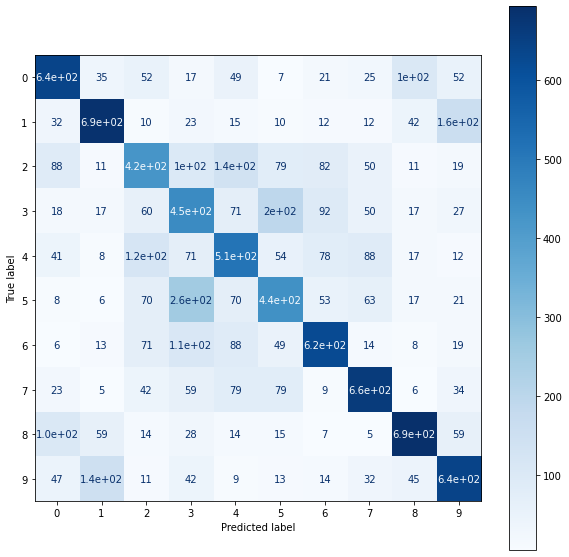


[[640  35  52  17  49   7  21  25 102  52]
 [ 32 688  10  23  15  10  12  12  42 156]
 [ 88  11 424 100 136  79  82  50  11  19]
 [ 18  17  60 453  71 195  92  50  17  27]
 [ 41   8 120  71 511  54  78  88  17  12]
 [  8   6  70 255  70 437  53  63  17  21]
 [  6  13  71 109  88  49 623  14   8  19]
 [ 23   5  42  59  79  79   9 664   6  34]
 [105  59  14  28  14  15   7   5 694  59]
 [ 47 145  11  42   9  13  14  32  45 642]]

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.64      0.64      1000
           1       0.70      0.69      0.69      1000
           2       0.49      0.42      0.45      1000
           3       0.39      0.45      0.42      1000
           4       0.49      0.51      0.50      1000
           5       0.47      0.44      0.45      1000
           6       0.63      0.62      0.63      1000
           7       0.66      0.66      0.66      1000
           8       0.72      0.69      0.71      1000
    

In [ ]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

Design MLP with Functional API Keras without dropout


Model: "cifar10_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3072)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         3146752     flatten[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1024)         0           dense[0][0]                      
______________________________________________________________________________________

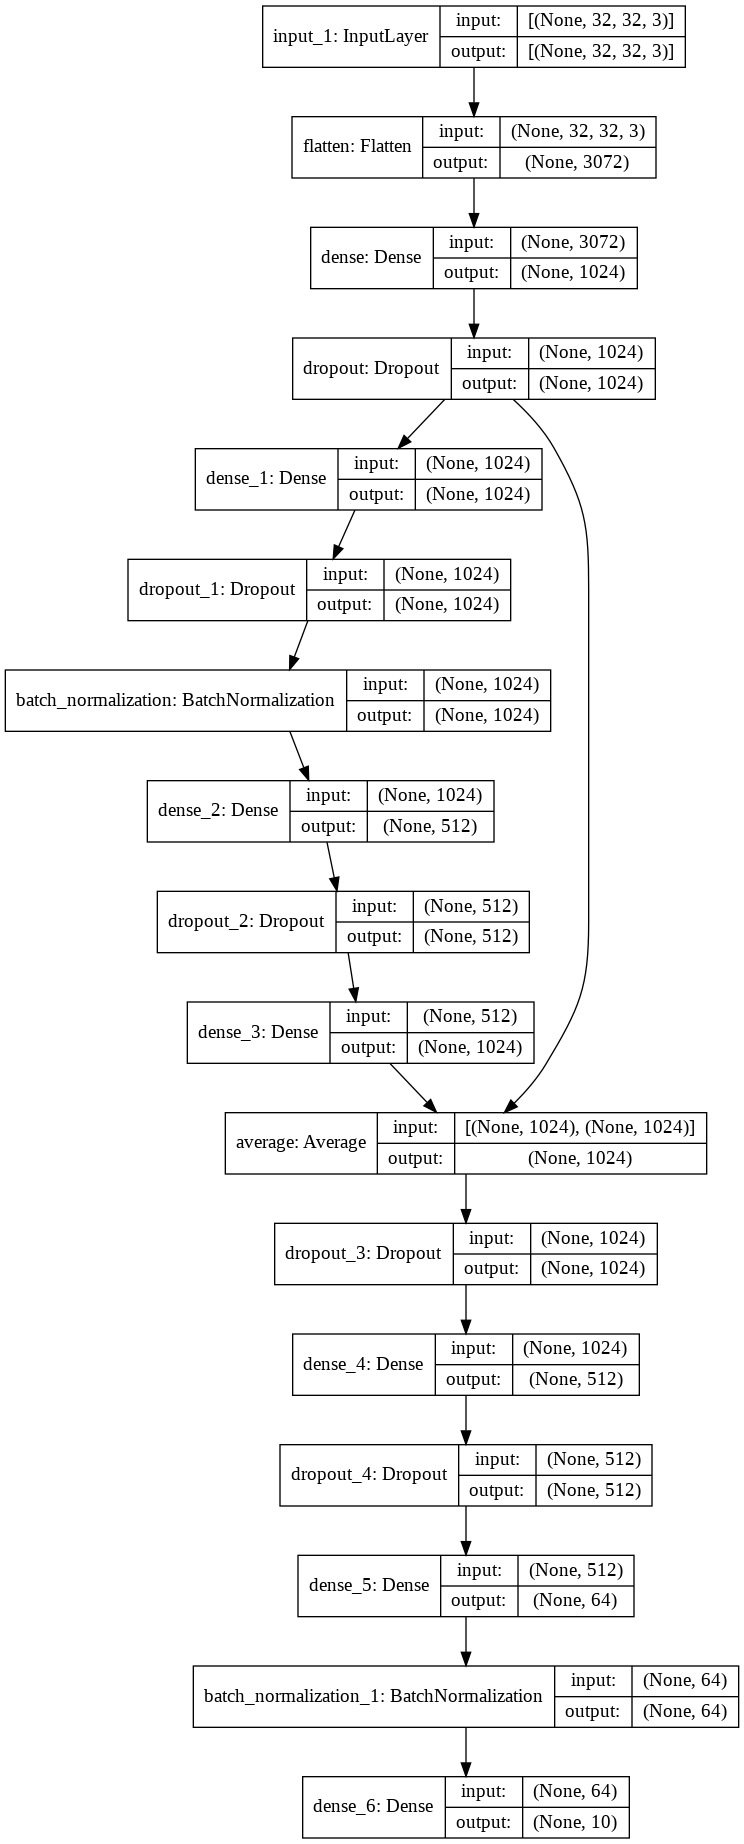

In [14]:
def createModel(dropout=0):
  inputs = keras.Input(shape=x_train.shape[1:])
  flatten = Flatten() (inputs)
  dense = Dense(1024, activation="relu")
  h1 = dense (flatten)
  d1 = Dropout(dropout) (h1)
  h2 = Dense(1024, activation="tanh")(d1)
  d2 = Dropout(dropout) (h2)
  b1 = BatchNormalization() (d2)
  h3 = Dense(512, activation="linear")(b1)
  d3 = Dropout(dropout) (h3)
  h4 = Dense(1024, activation="relu")(d3)
  concat = layers.Average()([d1, h4])
  d3 = Dropout(dropout) (concat)
  h5 = Dense(512, activation="tanh")(d3)
  d4 = Dropout(dropout) (h5)
  h6 = Dense(64, activation="linear")(d4)
  b2 = BatchNormalization() (h6)
  outputs = Dense(10, activation='softmax')(b2)
  model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_model")
  return model

model = createModel(dropout=0)
model.summary()
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)


Compile and train the model

In [ ]:

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.SGD(learning_rate=0.1, nesterov=True),
    # optimizer=keras.optimizers.RMSProp(),
    metrics=["accuracy"],
)

# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(25, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5)
]

history = model.fit(x_train, y_train, epochs=200, callbacks=my_callbacks,
                    batch_size=250, validation_data=(x_val, y_val), shuffle=True)


Epoch 1/200
480/480 [==============================] - 7s 12ms/step - loss: 1.6093 - accuracy: 0.4288 - val_loss: 1.6597 - val_accuracy: 0.4300
Epoch 2/200
480/480 [==============================] - 5s 11ms/step - loss: 1.3429 - accuracy: 0.5219 - val_loss: 1.6029 - val_accuracy: 0.4348
Epoch 3/200
480/480 [==============================] - 5s 11ms/step - loss: 1.2136 - accuracy: 0.5667 - val_loss: 1.6327 - val_accuracy: 0.4441
Epoch 4/200
480/480 [==============================] - 5s 11ms/step - loss: 1.1089 - accuracy: 0.6050 - val_loss: 1.4943 - val_accuracy: 0.4824
Epoch 5/200
480/480 [==============================] - 5s 11ms/step - loss: 1.0156 - accuracy: 0.6391 - val_loss: 1.5123 - val_accuracy: 0.5000
Epoch 6/200
480/480 [==============================] - 5s 11ms/step - loss: 0.9308 - accuracy: 0.6679 - val_loss: 1.4457 - val_accuracy: 0.5068
Epoch 7/200
480/480 [==============================] - 5s 11ms/step - loss: 0.8483 - accuracy: 0.6974 - val_loss: 1.6201 - val_accuracy:

Plot  accuracy and loss in epochs

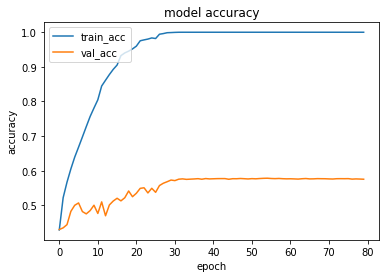

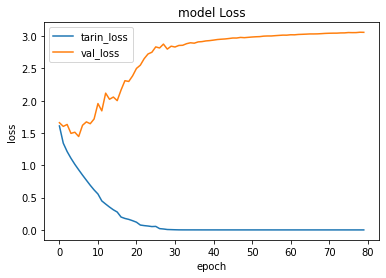

In [ ]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [ ]:
calculateAccuracyModel(model)

1200/1200 [==============================] - 7s 6ms/step - loss: 1.1646e-04 - accuracy: 1.0000
Train Accuracy: 100.00

100/100 [==============================] - 1s 5ms/step - loss: 2.9848 - accuracy: 0.5768
Test Accuracy: 57.68


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



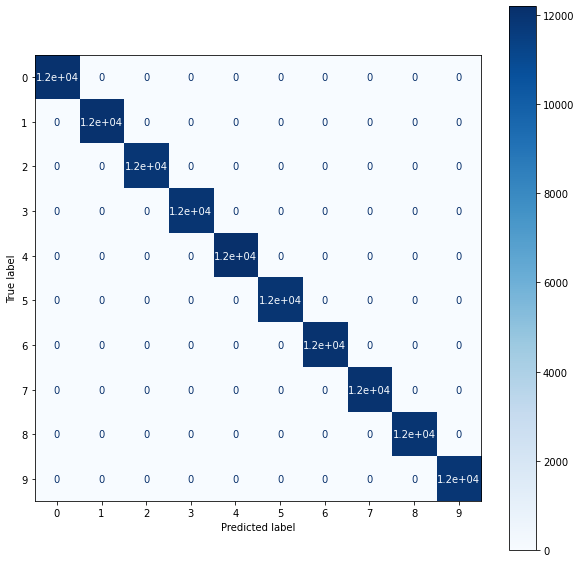


[[12081     0     0     0     0     0     0     0     0     0]
 [    0 12063     0     0     0     0     0     0     0     0]
 [    0     0 11910     0     0     0     0     0     0     0]
 [    0     0     0 11931     0     0     0     0     0     0]
 [    0     0     0     0 12201     0     0     0     0     0]
 [    0     0     0     0     0 11955     0     0     0     0]
 [    0     0     0     0     0     0 12012     0     0     0]
 [    0     0     0     0     0     0     0 12018     0     0]
 [    0     0     0     0     0     0     0     0 11949     0]
 [    0     0     0     0     0     0     0     0     0 11880]]

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12081
           1       1.00      1.00      1.00     12063
           2       1.00      1.00      1.00     11910
           3       1.00      1.00      1.00     11931
           4       1.00      1.00      1.00     12201
           5       1

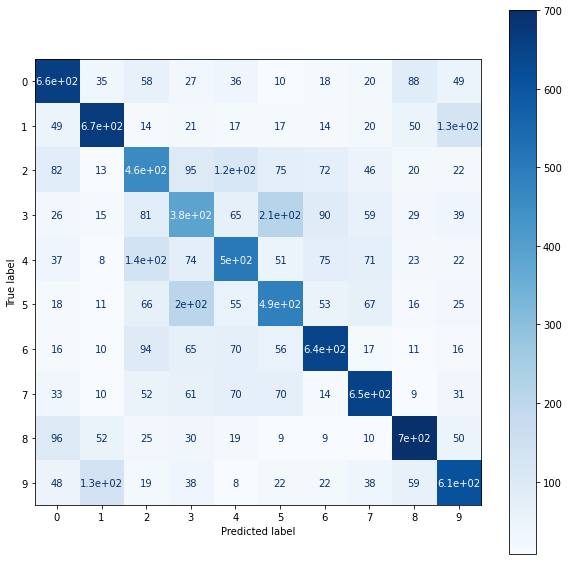


[[659  35  58  27  36  10  18  20  88  49]
 [ 49 669  14  21  17  17  14  20  50 129]
 [ 82  13 459  95 116  75  72  46  20  22]
 [ 26  15  81 384  65 212  90  59  29  39]
 [ 37   8 136  74 503  51  75  71  23  22]
 [ 18  11  66 203  55 486  53  67  16  25]
 [ 16  10  94  65  70  56 645  17  11  16]
 [ 33  10  52  61  70  70  14 650   9  31]
 [ 96  52  25  30  19   9   9  10 700  50]
 [ 48 133  19  38   8  22  22  38  59 613]]

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      1000
           1       0.70      0.67      0.68      1000
           2       0.46      0.46      0.46      1000
           3       0.38      0.38      0.38      1000
           4       0.52      0.50      0.51      1000
           5       0.48      0.49      0.48      1000
           6       0.64      0.65      0.64      1000
           7       0.65      0.65      0.65      1000
           8       0.70      0.70      0.70      1000
    

In [ ]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

Design MLP with Functional API Keras with dropout


Model: "cifar10_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3072)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1024)         3146752     flatten_1[0][0]                  
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1024)         0           dense_7[0][0]                    
______________________________________________________________________________________

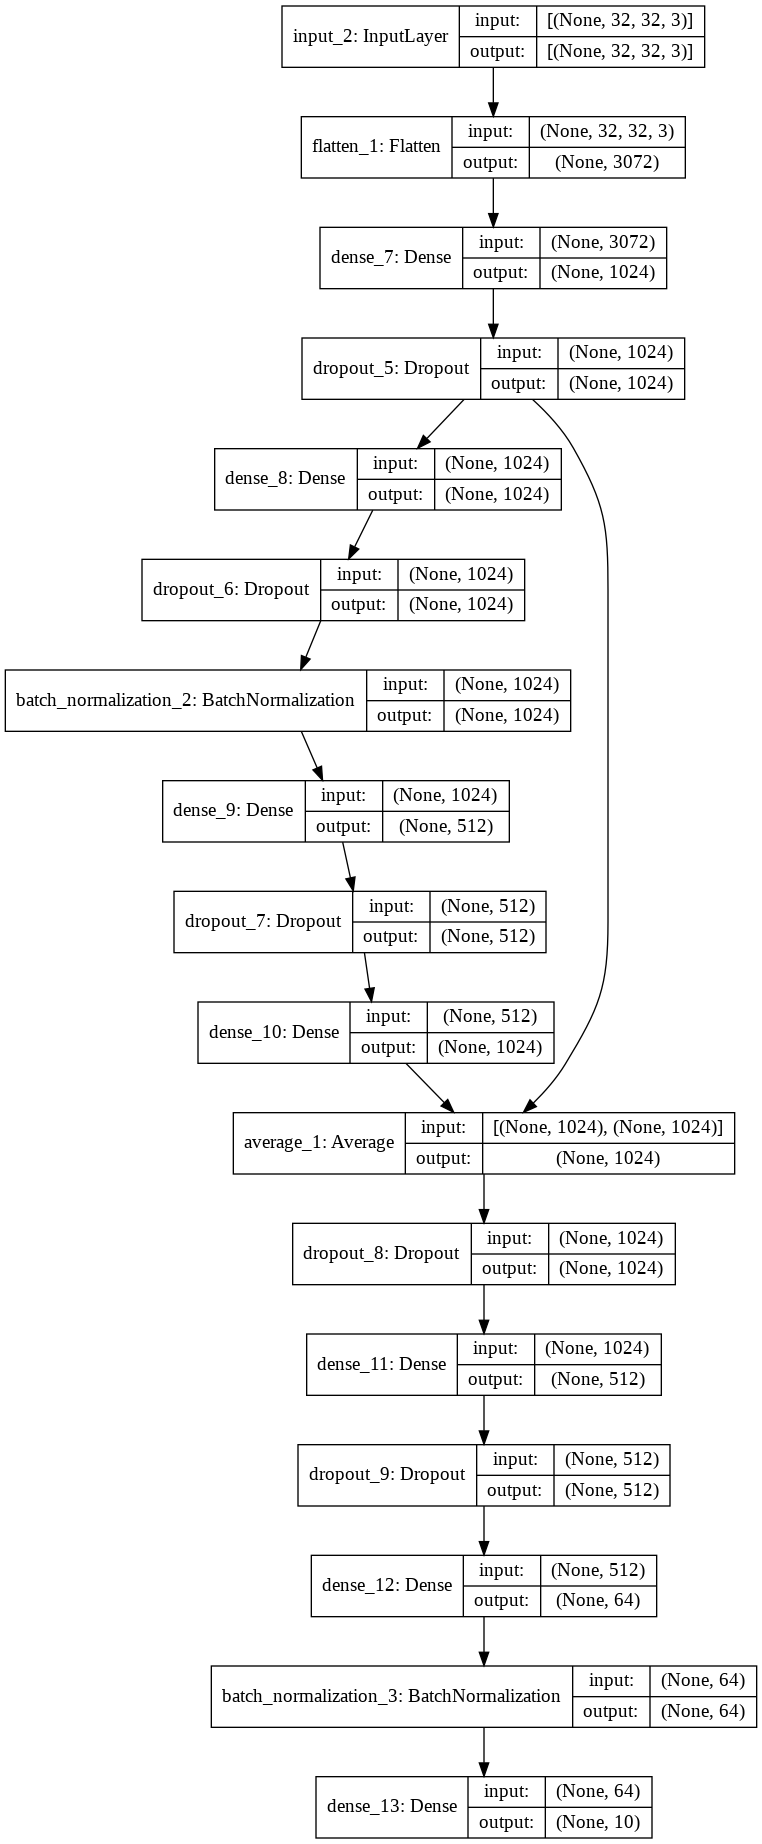

In [15]:
model = createModel(dropout=0.5)
model.summary()
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

Compile and train the model

In [16]:

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.SGD(learning_rate=0.1, nesterov=True),
    # optimizer=keras.optimizers.RMSProp(),
    metrics=["accuracy"],
)

# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(25, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.9, patience=5, min_lr=1e-5),
    keras.callbacks.ModelCheckpoint(filepath='bestModel.h5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
]

history = model.fit(x_train, y_train, epochs=200, callbacks=my_callbacks,
                    batch_size=250, validation_data=(x_val, y_val), shuffle=True)
model.save('bestModel.h5')

Epoch 1/200
480/480 [==============================] - 7s 6ms/step - loss: 2.0436 - accuracy: 0.2527 - val_loss: 1.7968 - val_accuracy: 0.3468

Epoch 00001: val_loss improved from inf to 1.79681, saving model to bestModel.h5
Epoch 2/200
 21/480 [>.............................] - ETA: 2s - loss: 1.8405 - accuracy: 0.3267

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


480/480 [==============================] - 3s 6ms/step - loss: 1.7817 - accuracy: 0.3478 - val_loss: 1.6675 - val_accuracy: 0.4017

Epoch 00002: val_loss improved from 1.79681 to 1.66751, saving model to bestModel.h5
Epoch 3/200
480/480 [==============================] - 3s 6ms/step - loss: 1.6963 - accuracy: 0.3836 - val_loss: 1.6211 - val_accuracy: 0.4147

Epoch 00003: val_loss improved from 1.66751 to 1.62111, saving model to bestModel.h5
Epoch 4/200
480/480 [==============================] - 3s 6ms/step - loss: 1.6450 - accuracy: 0.4050 - val_loss: 1.5951 - val_accuracy: 0.4288

Epoch 00004: val_loss improved from 1.62111 to 1.59513, saving model to bestModel.h5
Epoch 5/200
480/480 [==============================] - 3s 6ms/step - loss: 1.6049 - accuracy: 0.4191 - val_loss: 1.5868 - val_accuracy: 0.4341

Epoch 00005: val_loss improved from 1.59513 to 1.58681, saving model to bestModel.h5
Epoch 6/200
480/480 [==============================] - 3s 6ms/step - loss: 1.5702 - accuracy: 0.

Plot  accuracy and loss in epochs

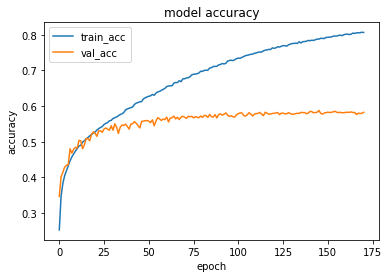

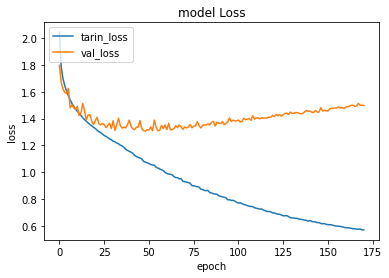

In [17]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [19]:
calculateAccuracyModel(model)

1200/1200 [==============================] - 4s 4ms/step - loss: 0.3311 - accuracy: 0.8966
Train Accuracy: 89.66

100/100 [==============================] - 0s 3ms/step - loss: 1.4468 - accuracy: 0.5788
Test Accuracy: 57.88


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



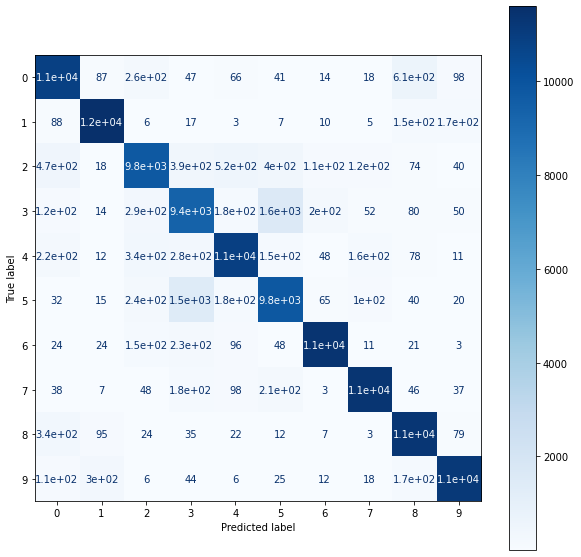


[[10838    87   264    47    66    41    14    18   608    98]
 [   88 11605     6    17     3     7    10     5   150   172]
 [  470    18  9776   386   525   396   110   115    74    40]
 [  117    14   288  9370   177  1579   204    52    80    50]
 [  224    12   336   280 10907   149    48   156    78    11]
 [   32    15   245  1453   175  9807    65   103    40    20]
 [   24    24   152   228    96    48 11405    11    21     3]
 [   38     7    48   176    98   209     3 11356    46    37]
 [  340    95    24    35    22    12     7     3 11332    79]
 [  110   295     6    44     6    25    12    18   172 11192]]

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     12081
           1       0.95      0.96      0.96     12063
           2       0.88      0.82      0.85     11910
           3       0.78      0.79      0.78     11931
           4       0.90      0.89      0.90     12201
           5       0

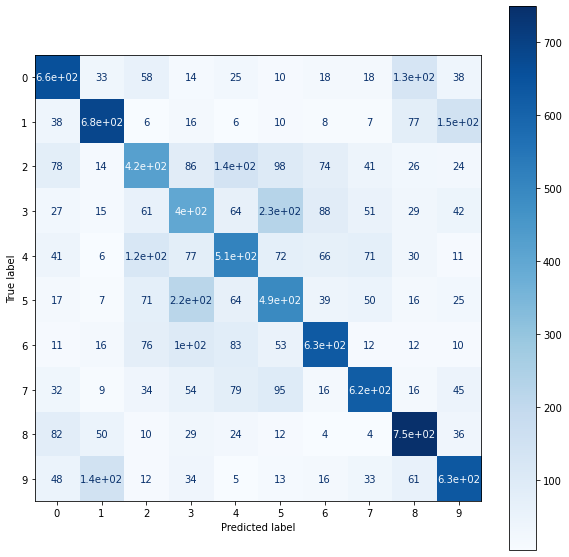


[[657  33  58  14  25  10  18  18 129  38]
 [ 38 684   6  16   6  10   8   7  77 148]
 [ 78  14 421  86 138  98  74  41  26  24]
 [ 27  15  61 397  64 226  88  51  29  42]
 [ 41   6 118  77 508  72  66  71  30  11]
 [ 17   7  71 219  64 492  39  50  16  25]
 [ 11  16  76 100  83  53 627  12  12  10]
 [ 32   9  34  54  79  95  16 620  16  45]
 [ 82  50  10  29  24  12   4   4 749  36]
 [ 48 145  12  34   5  13  16  33  61 633]]

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      1000
           1       0.70      0.68      0.69      1000
           2       0.49      0.42      0.45      1000
           3       0.39      0.40      0.39      1000
           4       0.51      0.51      0.51      1000
           5       0.46      0.49      0.47      1000
           6       0.66      0.63      0.64      1000
           7       0.68      0.62      0.65      1000
           8       0.65      0.75      0.70      1000
    

In [20]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

Inception V1

In [ ]:
# function for creating a projected inception module
def inception_module1(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
  # 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
  # 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
  # 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
  return layer_out# function for creating a projected inception module

Inception V3

In [ ]:
# function for creating a projected inception module
def inception_module3(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
  # 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3_1 = Conv2D(f2_out, (1,3), padding='same', activation='relu')(conv3)
  conv3_2 = Conv2D(f2_out, (3,1), padding='same', activation='relu')(conv3_1)
  # 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3_1_1 = Conv2D(f3_out, (1,3), padding='same', activation='relu')(conv5)
  conv3_1_2 = Conv2D(f3_out, (3,1), padding='same', activation='relu')(conv3_1_1)
  conv3_2_1 = Conv2D(f3_out, (1,3), padding='same', activation='relu')(conv3_1_2)
  conv3_2_2 = Conv2D(f3_out, (3,1), padding='same', activation='relu')(conv3_2_1)
  # 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv3_2, conv3_2_2, pool], axis=-1)
  return layer_out# function for creating a projected inception module


CNN model with inception module 1

Model: "cifar10_cnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   4736        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 13, 13, 32)   128         max_pooling2d[0][0]              
__________________________________________________________________________________

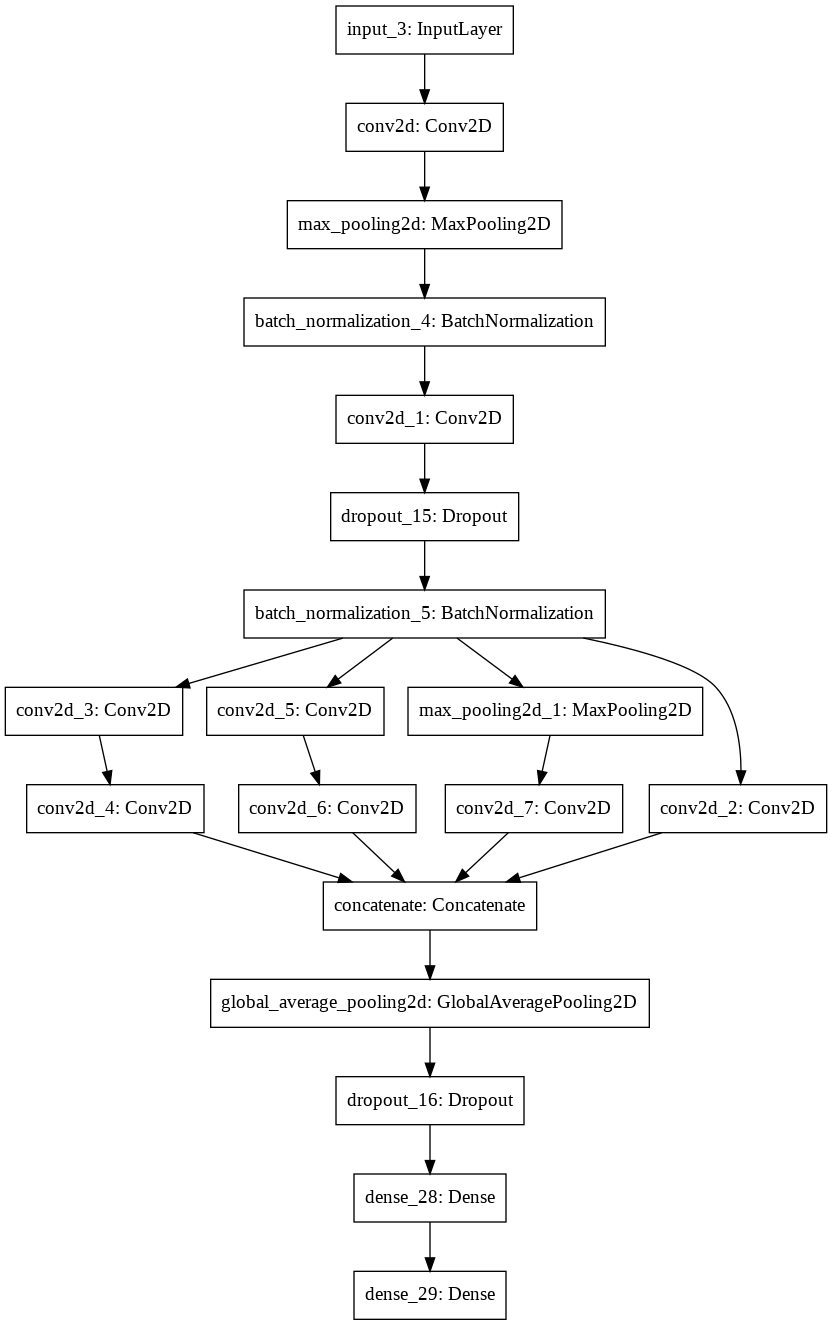

In [ ]:

inputs = keras.Input(shape=x_train.shape[1:])
conv1 = Conv2D(32, kernel_size=7, activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(conv1)
b1 = BatchNormalization() (pool1)
conv2 = Conv2D(64, kernel_size=3, activation='relu')(b1)
d0 = Dropout(0.2) (conv2)
b2 = BatchNormalization() (d0)

layer = inception_module1(b2, 32, 48, 64, 8, 16, 16)
globalPooling1 = GlobalAveragePooling2D()(layer)
d1 = Dropout(0.4)(globalPooling1)
hidden2 = Dense(32, activation='linear')(d1)
outputs = Dense(10, activation='softmax')(hidden2)
model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_cnn_model")

model.summary()
keras.utils.plot_model(model, "my_first_cnn_model_with_shape_info.png")

Compile and train first cnn model

In [ ]:

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    # optimizer=keras.optimizers.SGD(learning_rate=0.1, nesterov=True),
    optimizer=keras.optimizers.Adam(),
    # optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9),
    # optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(5, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.75, patience=5, min_lr=1e-5)
]
history = model.fit(x_train, y_train, epochs=100, callbacks=my_callbacks,
                    batch_size=64,  validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
1875/1875 [==============================] - 29s 12ms/step - loss: 1.5693 - accuracy: 0.4182 - val_loss: 1.2883 - val_accuracy: 0.5325
Epoch 2/100
1875/1875 [==============================] - 22s 12ms/step - loss: 1.2469 - accuracy: 0.5537 - val_loss: 1.2189 - val_accuracy: 0.5683
Epoch 3/100
1875/1875 [==============================] - 23s 12ms/step - loss: 1.1071 - accuracy: 0.6050 - val_loss: 1.0147 - val_accuracy: 0.6455
Epoch 4/100
1875/1875 [==============================] - 23s 12ms/step - loss: 1.0312 - accuracy: 0.6347 - val_loss: 1.0557 - val_accuracy: 0.6283

wait mode, step: 1
Epoch 5/100
1875/1875 [==============================] - 22s 12ms/step - loss: 0.9749 - accuracy: 0.6537 - val_loss: 0.9605 - val_accuracy: 0.6632
Epoch 6/100
1875/1875 [==============================] - 23s 12ms/step - loss: 0.9320 - accuracy: 0.6718 - val_loss: 0.8675 - val_accuracy: 0.6942
Epoch 7/100
1875/1875 [==============================] - 22s 12ms/step - loss: 0.8979 - accuracy: 

Plot  accuracy and loss in epochs

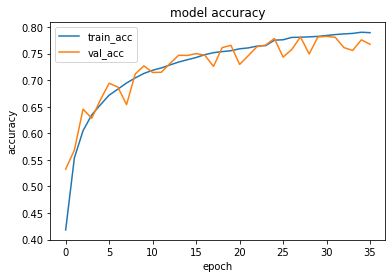

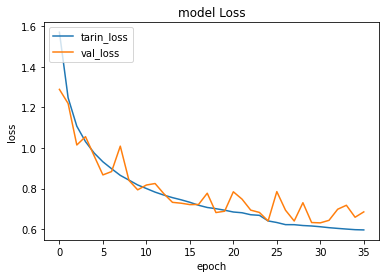

In [ ]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [ ]:
calculateAccuracyModel(model)

1200/1200 [==============================] - 10s 8ms/step - loss: 0.4186 - accuracy: 0.8568
Train Accuracy: 85.68

100/100 [==============================] - 1s 8ms/step - loss: 0.6359 - accuracy: 0.7848
Test Accuracy: 78.48


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



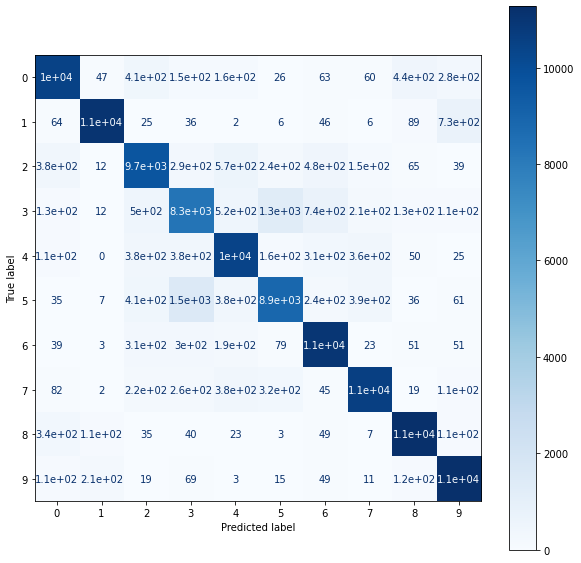


[[10445    47   407   149   160    26    63    60   442   282]
 [   64 11057    25    36     2     6    46     6    89   732]
 [  385    12  9684   289   574   241   475   146    65    39]
 [  126    12   499  8278   521  1309   740   209   127   110]
 [  108     0   380   375 10428   159   314   362    50    25]
 [   35     7   413  1532   382  8868   235   386    36    61]
 [   39     3   307   298   190    79 10971    23    51    51]
 [   82     2   218   262   383   318    45 10576    19   113]
 [  336   114    35    40    23     3    49     7 11236   106]
 [  113   210    19    69     3    15    49    11   120 11271]]

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88     12081
           1       0.96      0.92      0.94     12063
           2       0.81      0.81      0.81     11910
           3       0.73      0.69      0.71     11931
           4       0.82      0.85      0.84     12201
           5       0

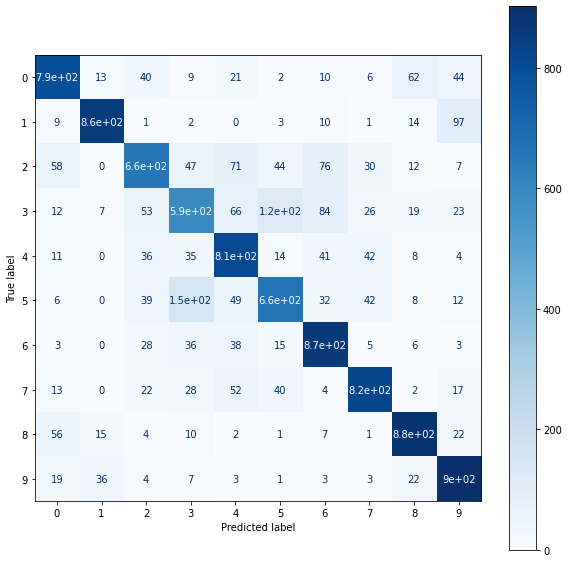


[[793  13  40   9  21   2  10   6  62  44]
 [  9 863   1   2   0   3  10   1  14  97]
 [ 58   0 655  47  71  44  76  30  12   7]
 [ 12   7  53 591  66 119  84  26  19  23]
 [ 11   0  36  35 809  14  41  42   8   4]
 [  6   0  39 147  49 665  32  42   8  12]
 [  3   0  28  36  38  15 866   5   6   3]
 [ 13   0  22  28  52  40   4 822   2  17]
 [ 56  15   4  10   2   1   7   1 882  22]
 [ 19  36   4   7   3   1   3   3  22 902]]

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1000
           1       0.92      0.86      0.89      1000
           2       0.74      0.66      0.70      1000
           3       0.65      0.59      0.62      1000
           4       0.73      0.81      0.77      1000
           5       0.74      0.67      0.70      1000
           6       0.76      0.87      0.81      1000
           7       0.84      0.82      0.83      1000
           8       0.85      0.88      0.87      1000
    

In [ ]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)

CNN model with inception module 3

Model: "cifar10_cnn_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 26, 26, 32)   4736        input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 32)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 12, 12, 32)   128         max_pooling2d_2[0][0]            
__________________________________________________________________________________

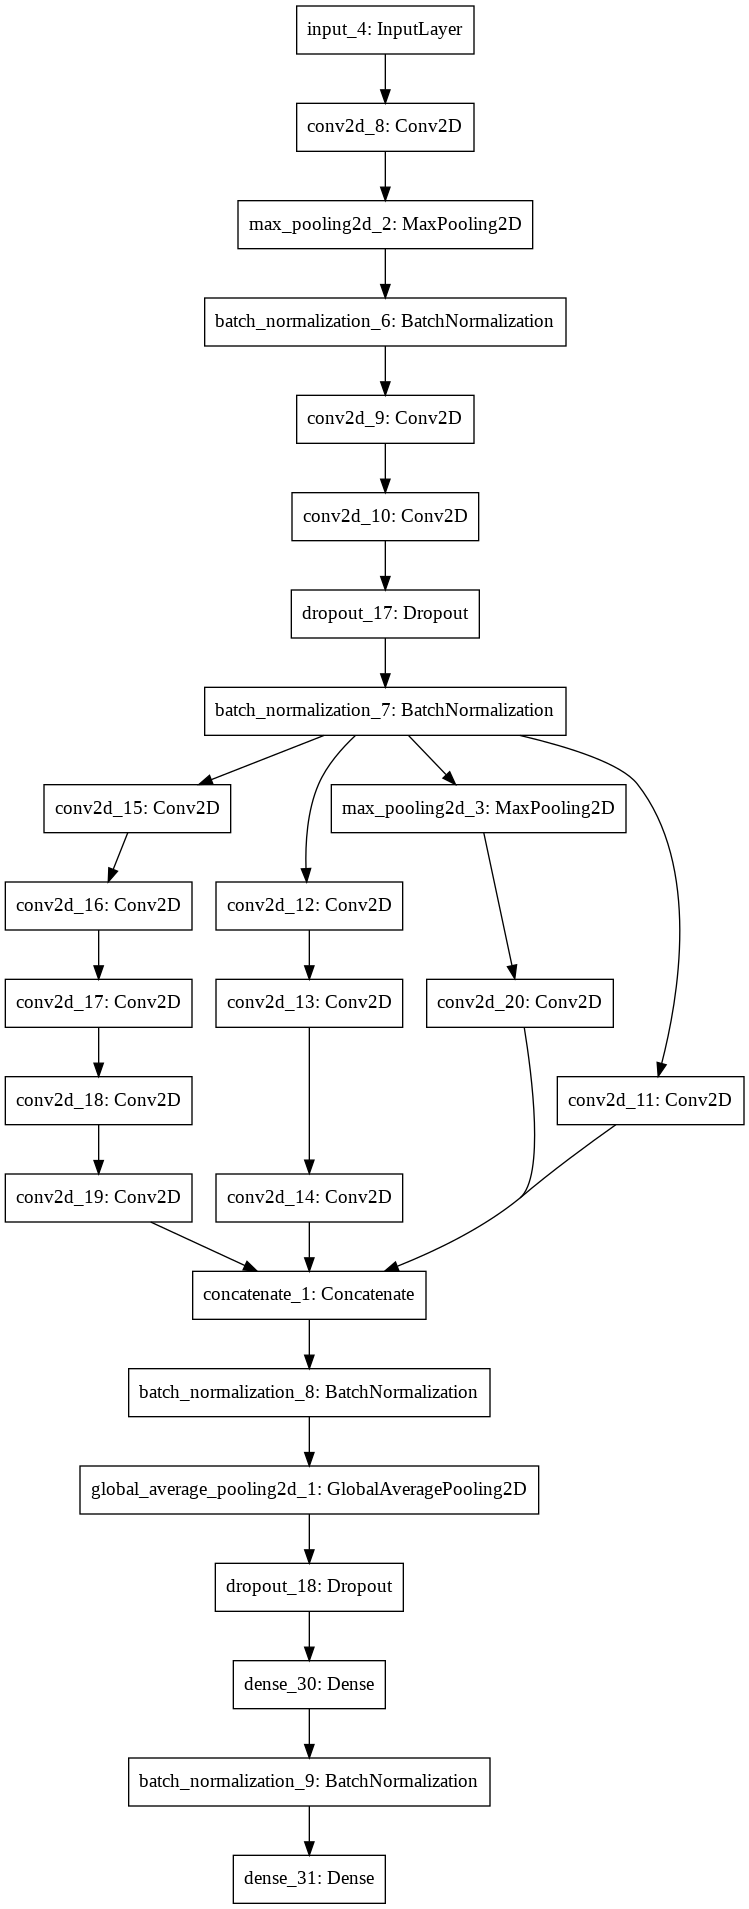

In [ ]:
inputs = keras.Input(shape=x_train.shape[1:])
conv1 = Conv2D(32, kernel_size=7, activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=3, strides=2)(conv1)
b1 = BatchNormalization() (pool1)
conv2 = Conv2D(64, kernel_size=(1, 3), activation='relu')(b1)
conv2 = Conv2D(64, kernel_size=(3, 1), activation='relu')(conv2)
d0 = Dropout(0.2)(conv2)
b2 = BatchNormalization() (d0)

layer = inception_module3(b2, 32, 48, 64, 8, 16, 16)
b3 = BatchNormalization() (layer)
globalPooling1 = GlobalAveragePooling2D()(b3)
d1 = Dropout(0.4)(globalPooling1)
fc1 = Dense(32, activation='linear')(d1)
b4 = BatchNormalization() (fc1)
outputs = Dense(10, activation='softmax')(b4)
model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_cnn_model")

model.summary()
keras.utils.plot_model(model, "my_first_cnn_model_with_shape_info.png")

Compile and train first cnn model

In [ ]:

model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    # optimizer=keras.optimizers.SGD(learning_rate=0.1, nesterov=True),
    optimizer=keras.optimizers.Adam(),
    # optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9),
    # optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
)

# fit the keras model on the dataset
my_callbacks = [
    EarlyStoppingCallback(5, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto',
                                      factor=0.75, patience=5, min_lr=1e-5)
]
history = model.fit(x_train, y_train, epochs=100, callbacks=my_callbacks,
                    batch_size=64,  validation_data=(x_val, y_val), shuffle=True)

Epoch 1/100
1875/1875 [==============================] - 30s 15ms/step - loss: 1.4620 - accuracy: 0.4672 - val_loss: 1.2682 - val_accuracy: 0.5226
Epoch 2/100
1875/1875 [==============================] - 27s 15ms/step - loss: 1.1229 - accuracy: 0.6022 - val_loss: 1.1599 - val_accuracy: 0.5873
Epoch 3/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.9770 - accuracy: 0.6564 - val_loss: 0.9424 - val_accuracy: 0.6621
Epoch 4/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.8818 - accuracy: 0.6915 - val_loss: 0.9457 - val_accuracy: 0.6677
Epoch 5/100
1875/1875 [==============================] - 27s 15ms/step - loss: 0.8194 - accuracy: 0.7136 - val_loss: 1.0331 - val_accuracy: 0.6512

wait mode, step: 1
Epoch 6/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.7698 - accuracy: 0.7319 - val_loss: 0.9633 - val_accuracy: 0.6695
Epoch 7/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.7343 - accuracy: 

Plot  accuracy and loss in epochs

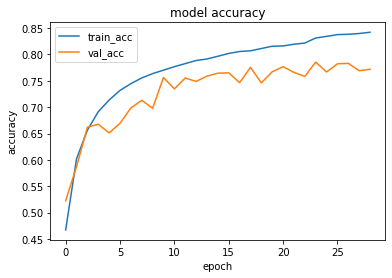

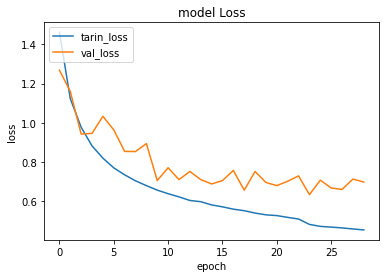

In [ ]:
plotAccuracyLoss(history)

Calculate the accuracy of model in train and test 

In [ ]:
calculateAccuracyModel(model)

1200/1200 [==============================] - 9s 7ms/step - loss: 0.3399 - accuracy: 0.8845
Train Accuracy: 88.45

100/100 [==============================] - 1s 8ms/step - loss: 0.6353 - accuracy: 0.7875
Test Accuracy: 78.75


Evaluate the model performance

Model evaluation on train dataset
Confusion Matrix



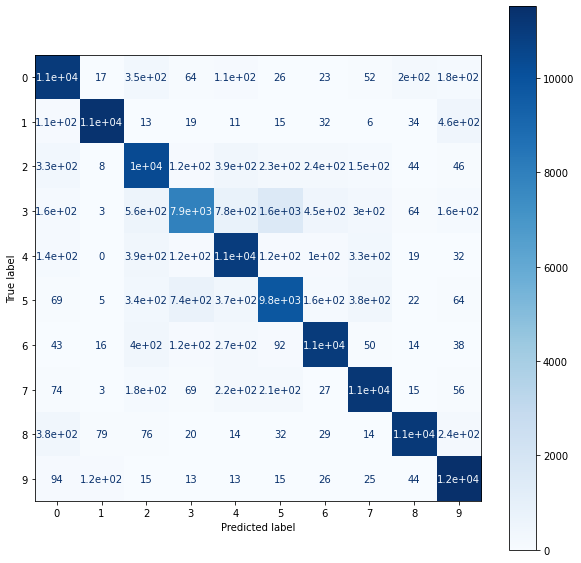


[[11064    17   351    64   106    26    23    52   199   179]
 [  109 11365    13    19    11    15    32     6    34   459]
 [  327     8 10341   119   394   233   244   154    44    46]
 [  161     3   561  7897   782  1555   451   297    64   160]
 [  143     0   390   121 10947   121   101   327    19    32]
 [   69     5   344   741   368  9798   165   379    22    64]
 [   43    16   402   116   266    92 10975    50    14    38]
 [   74     3   175    69   217   208    27 11174    15    56]
 [  377    79    76    20    14    32    29    14 11065   243]
 [   94   121    15    13    13    15    26    25    44 11514]]

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     12081
           1       0.98      0.94      0.96     12063
           2       0.82      0.87      0.84     11910
           3       0.86      0.66      0.75     11931
           4       0.83      0.90      0.86     12201
           5       0

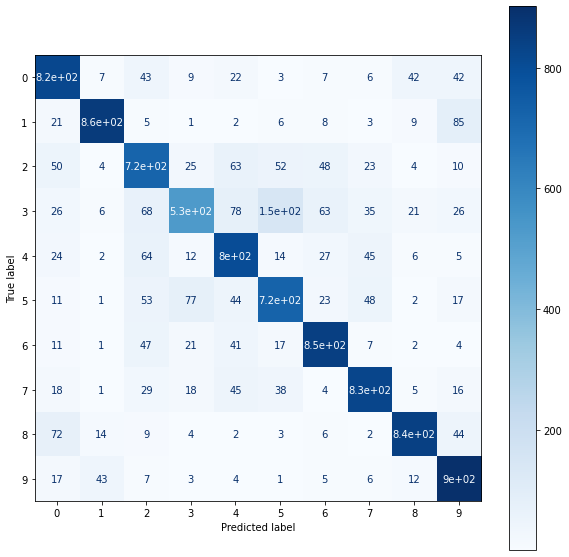


[[819   7  43   9  22   3   7   6  42  42]
 [ 21 860   5   1   2   6   8   3   9  85]
 [ 50   4 721  25  63  52  48  23   4  10]
 [ 26   6  68 529  78 148  63  35  21  26]
 [ 24   2  64  12 801  14  27  45   6   5]
 [ 11   1  53  77  44 724  23  48   2  17]
 [ 11   1  47  21  41  17 849   7   2   4]
 [ 18   1  29  18  45  38   4 826   5  16]
 [ 72  14   9   4   2   3   6   2 844  44]
 [ 17  43   7   3   4   1   5   6  12 902]]

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1000
           1       0.92      0.86      0.89      1000
           2       0.69      0.72      0.70      1000
           3       0.76      0.53      0.62      1000
           4       0.73      0.80      0.76      1000
           5       0.72      0.72      0.72      1000
           6       0.82      0.85      0.83      1000
           7       0.83      0.83      0.83      1000
           8       0.89      0.84      0.87      1000
    

In [ ]:
print('Model evaluation on train dataset')
reportPerformance(model, x_train, y_train)
print()
print('Model evaluation on test dataset')
reportPerformance(model, x_test, y_test)